### Import python libraries and local functions. 

In [8]:
from glob import glob
import numpy as np
import pyabf
import matplotlib.pyplot as plt
import matplotlib as mp
from open_abf import plot_swps, get_sweeps, swp_window, get_protocol, files_from_protocol
from CSHL import IV_style
from scipy.optimize import leastsq
import functions as func
%matplotlib widget

### Define your path to your data
#### The glob function helps you filter your files

In [2]:
pathToData = "/home/alan/Documents/LAB/CSHL/Data/"
folders = glob(pathToData+"*")
folders

['/home/alan/Documents/LAB/CSHL/Data/Cav',
 '/home/alan/Documents/LAB/CSHL/Data/Kv',
 '/home/alan/Documents/LAB/CSHL/Data/_test.mat',
 '/home/alan/Documents/LAB/CSHL/Data/Gly',
 '/home/alan/Documents/LAB/CSHL/Data/HCN',
 '/home/alan/Documents/LAB/CSHL/Data/Nav']

In [3]:
files = glob(folders[1]+"/*/*.abf")
files

['/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0003.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0004.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0002.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0001.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0000.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0005.abf']

In [4]:
get_protocol(files)

['kv protocol 1',
 'kv protocol 1',
 'kv protocol 1',
 'kv protocol 2',
 'kv protocol 1',
 'kv protocol 1']

## Activation
### IV curve 

In [5]:
iv_files = files_from_protocol('1',files)
iv_files

['/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0003.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0004.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0002.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0000.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0005.abf']

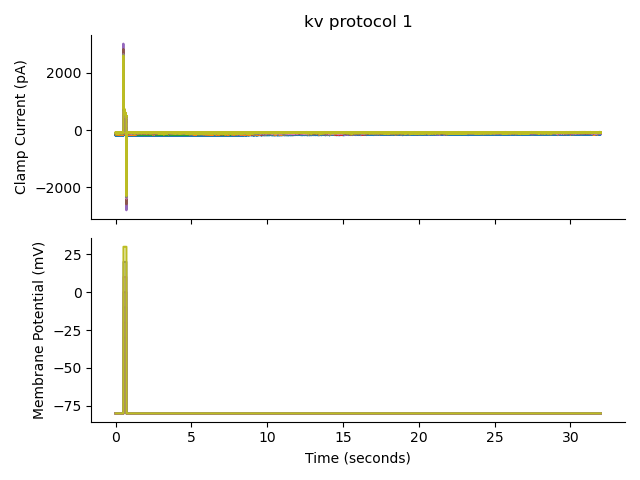

In [6]:
plt.close('all')
## Explore files
f = iv_files[1]
plot_swps(f)

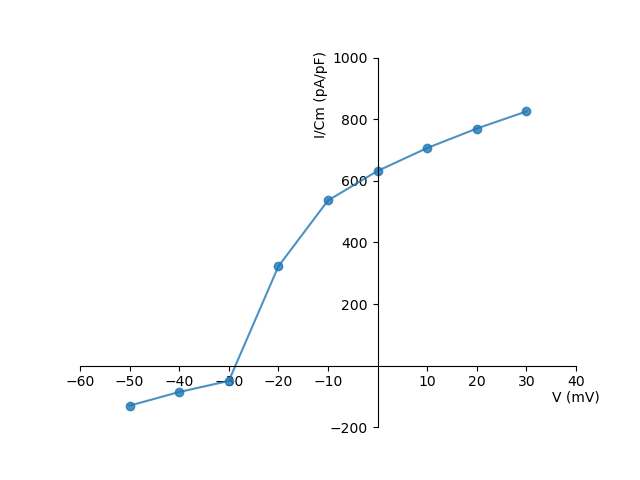

In [20]:
## Extract the sweeps
swps, swp_time, sr = get_sweeps(f)
## The mean on your voltage step:
v_start = 0.512
v_end = 0.7
voltage_step = np.mean(swp_window(swps,v_start,v_end,sr,channel=1),axis=1)
## the pic response in your current:
i_start = 0.512
i_end = 0.55
current_window = swp_window(swps,i_start,i_end,sr,channel=0)
current_response = np.array([swp[np.argmax(np.abs(swp))] for swp in current_window])
## Create a figure plot with this line:
fig,ax = plt.subplots()
## the ax.plot(x,y,'line, dot,...') will plot your data to the figure
ax.plot(voltage_step,current_response,'-o',alpha=0.8)
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Current response (pA)')
IV_style(ax,ycoord=(0.5,0.9),xcoord=(1,0.1))
plt.show()

### activation curve

#### Normalise

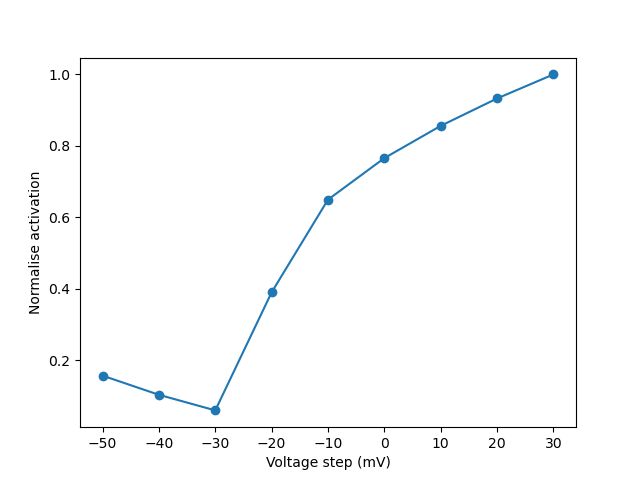

In [23]:
norm = np.abs(current_response/current_response.max())
fig, ax = plt.subplots()
ax.plot(voltage_step,norm,'-o')
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Normalise activation')
plt.show()

### Then when you have the reversal potential

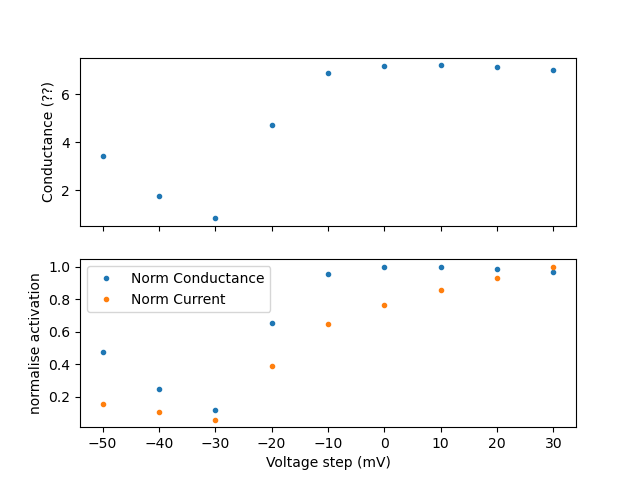

In [28]:
## reversal potential in mV
E_rev = -88 ## from the IV curve
conductance = np.abs(current_response/(voltage_step - E_rev))
## normalise
norm_g = conductance/conductance.max()
fig, ax = plt.subplots(2,sharex=True)
ax[0].plot(voltage_step,conductance,'.')
ax[1].plot(voltage_step,norm_g,'.',label='Norm Conductance')
ax[1].plot(voltage_step,norm,'.',label='Norm Current')
ax[1].set_ylabel('normalise activation')
ax[1].set_xlabel('Voltage step (mV)')
ax[0].set_ylabel('Conductance (??)')
ax[1].legend()
plt.show()

#### fit the activation curve

In [29]:
def fun_boltz(x, p):
    """Fit function for growth: single exponential + offset
    p[0] : V 50
    p[1] : slope
    """
    return 1.0 - (1.0/(1.0+np.exp((x-p[0])/p[1])))

def minimize_fun(p, x, y):
    return y-fun_boltz(x, p)

v50_init = 0.0
slope_init = 1.0
x = voltage_step
y = norm_g
p_guess = (v50_init,slope_init)
fit_boltz = leastsq(minimize_fun, p_guess, args=(x, y),full_output=True)
fit_params = fit_boltz[0]
print(fit_boltz[0])
fit_x = np.arange(x[0],x[-1],1e-3)
fit_fun = fun_boltz(fit_x,fit_params)
ax[1].plot(fit_x,fit_fun,label=f"fit\n slope={fit_params[1]}\n V50={fit_params[0]} ")
ax[1].legend()

[-26.3985  11.3205]


### Tail Current 
#### Extract the current at the end of the voltage step:

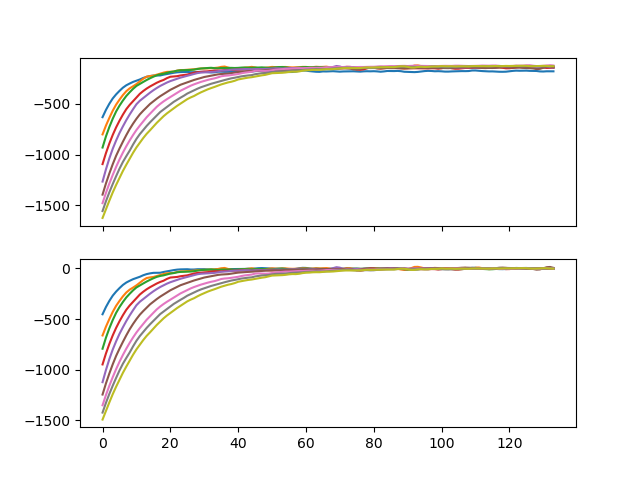

In [30]:
# Set the real time end of the step.
theorical_start = 0.71
## then the window were you want to fit
## Technically the start should be the same
## But because of Cp transients you want to cut the begining.
## Then the fit will extrapolate the first part of the trace.
i_start = 0.7103 
i_end = 0.7130
tail_current = swp_window(swps,i_start,i_end,sr,channel=0)
## normalise with baseline (end of tail =0 )
baseline = np.mean(tail_current[:,-10:],axis=1)
norm_tail_current = tail_current - baseline[:, np.newaxis]
fig,ax = plt.subplots(2,sharex=True)
ax[0].plot(tail_current.T)
ax[1].plot(norm_tail_current.T)
plt.show()

In [52]:
def fit_exp(x_axis,ydata,p_guess,p_gain):
    def fun_exp(x, p, p_gain):
        """Fit function for decay: single exponential + offset
        p[0] : amplitude
        p[1] : tau
        """
        ## THIS IS CRUCIAL !
        ## for a good fit you need to have the 
        ## params in the range of ~ 1-10 idealy
        amp = p[0] * p_gain[0] ## should be pA
        tau = p[1] * p_gain[1] ## should be sec
        return 1 - (amp*np.exp(-x/tau))
    
    def minimize_fun(p, x, y, p_gain):
        return y-fun_exp(x, p, p_gain)
    
    x = x_axis
    y = ydata
    fit_exp = leastsq(minimize_fun, p_guess, args=(x, y, p_gain))
    fit_params = fit_exp[0]
    fit_trace = fun_exp(x,fit_params,p_gain)
    print(f'Amplitude = {round(fit_params[0]*p_gain[0])} pA // Tau = {round(fit_params[1]*p_gain[0],2)} ms')

    return fit_params,fit_trace

In [37]:
Cp_delta = i_start - theorical_start
time = (np.arange(len(tail_current[0])) / sr ) + Cp_delta
time

array([0.0003, 0.0003, 0.0003, ..., 0.0029, 0.0029, 0.003 ])

#### Use color map to have more visual graph

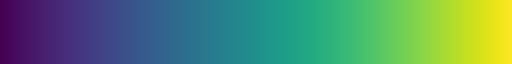

In [38]:
mp.colormaps['viridis'] # You can check out matploltlib colors maps for more colors

Sweep 0
Amplitude = 4658 pA // Tau = 127.53 ms
Sweep 1
Amplitude = 5313 pA // Tau = 143.59 ms
Sweep 2
Amplitude = 6352 pA // Tau = 143.34 ms
Sweep 3
Amplitude = 5143 pA // Tau = 175.94 ms
Sweep 4
Amplitude = 5454 pA // Tau = 188.34 ms
Sweep 5
Amplitude = 4586 pA // Tau = 228.45 ms
Sweep 6
Amplitude = 3996 pA // Tau = 273.77 ms
Sweep 7
Amplitude = 3766 pA // Tau = 304.73 ms
Sweep 8
Amplitude = 3674 pA // Tau = 331.33 ms


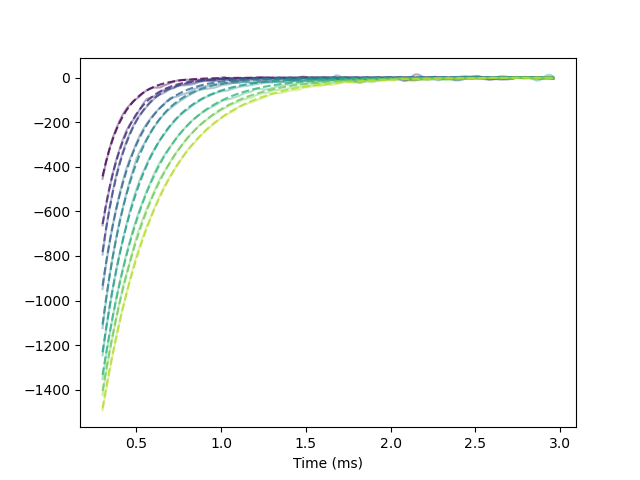

In [54]:
## These are Essential
## You want the guess to be around 1-100
## you then need to adjust the gain
p_guess = [4,1] ## start value of the fit 
p_gain = [1e3,1e-3] ## gain to adjust to the real values !
fig,ax = plt.subplots()
cmap = mp.colormaps['viridis']
fitted_params = []
for i,curr in enumerate(norm_tail_current):
    print(f'Sweep {i}')
    p_fit,t_fit = fit_exp(time,curr,p_guess,p_gain)
    fitted_params.append(p_fit)
    color = cmap(i/len(tail_current))[:-1]
    ax.plot(time*1e3,curr,color=color,alpha=0.4)
    ax.plot(time*1e3,t_fit,'--',color=color,alpha=0.8)
    ax.set_xlabel('Time (ms)')
fitted_params = np.array(fitted_params) * np.array([1e3,1e-3])
plt.show()

Text(0, 0.5, 'Tau (ms)')

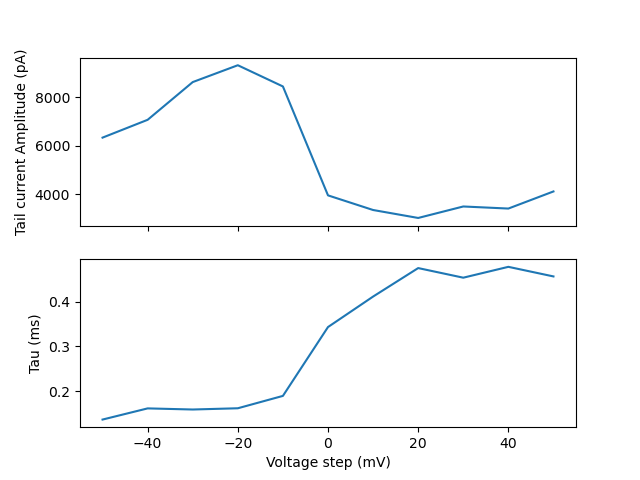

In [49]:
fig,ax = plt.subplots(2,sharex=True)
ax[0].plot(voltage_step,fitted_params[:,0])
ax[1].plot(voltage_step,fitted_params[:,1])
ax[1].set_xlabel('Voltage step (mV)')
ax[0].set_ylabel('Tail current Amplitude (pA)')
ax[1].set_ylabel('Tau (ms)')

### Deactivation you can do it I beleive in you :) 

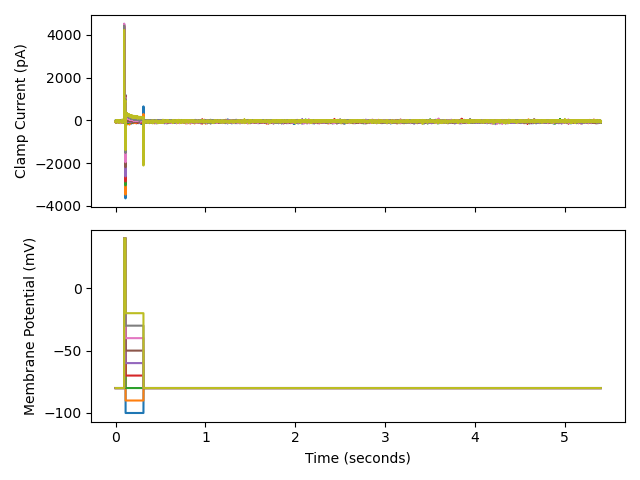

In [50]:
f = files[3]
plot_swps(f)

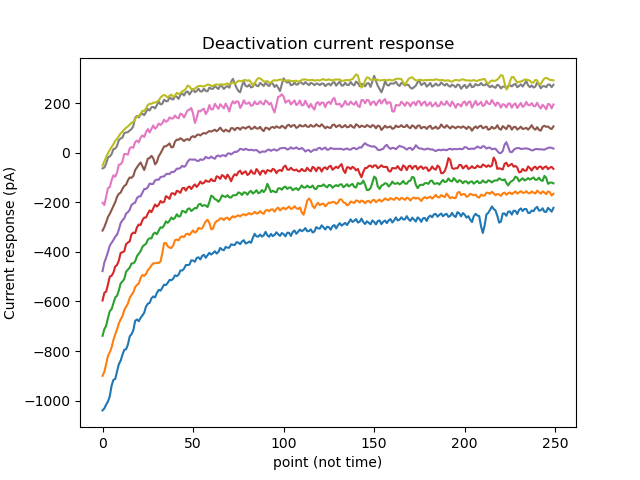

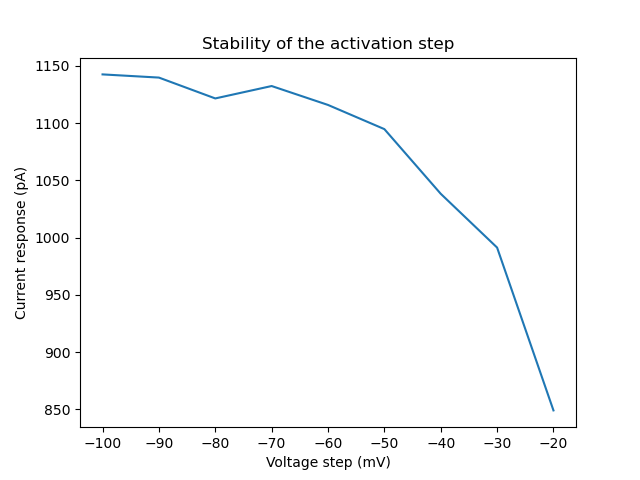

In [62]:
plt.close('all')
swps, swp_time, sr = get_sweeps(f)
## The mean on your voltage step:
v_start = 0.125
v_end = 0.3
voltage_step = np.mean(swp_window(swps,v_start,v_end,sr,channel=1),axis=1)
## the baseline current:
i_start = 0.05
i_end = 0.08
current_baseline = np.max(swp_window(swps,i_start,i_end,sr,channel=0),axis=1)
## the reference full activation pic curren response:
i_start = 0.107
i_end = 0.109
ref_current = np.mean(swp_window(swps,i_start,i_end,sr,channel=0),axis=1) - current_baseline  
## the pic response in your current:
i_start = 0.110
i_end = 0.115
current_response = swp_window(swps,i_start,i_end,sr,channel=0) - current_baseline[:, np.newaxis]

## Create a figure plot with this line:
fig,ax = plt.subplots()
ax.set_title('Stability of the activation step')
ax.plot(voltage_step,ref_current)
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Current response (pA)')
## Create a figure plot with this line:
fig,ax = plt.subplots()
ax.set_title('Deactivation current response')
ax.plot(current_response.T)
ax.set_xlabel('point (not time)')
ax.set_ylabel('Current response (pA)')
plt.show()

### You will need to fit this with a function : The same as the Tail current 

### Pharmacology

In [1]:
files = glob(folders[0]+"/*")
files

NameError: name 'glob' is not defined

In [ ]:
swps, swp_time, sr = get_sweeps(f)
## the pic response in your current:
i_start = 0.11341
i_end = 0.1155
current_response = np.min(swp_window(swps,i_start,i_end,sr,channel=0),axis=1)
## Create a figure plot with this line:
fig,ax = plt.subplots()
## the ax.plot(x,y,'line, dot,...') will plot your data to the figure
ax.plot(voltage_step,current_response,'.')
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Current response (pA)')
plt.show()